Задача:

🔸 разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

🔸оценить качество алгоритма по метрике accuracy@5

🔸*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


Данные:
- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

In [76]:
!pip install faiss-cpu

In [77]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler

import time
from tqdm.notebook import tqdm
tqdm.pandas()

import faiss

import zipfile
import requests
from urllib.parse import urlencode


from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # загрузим файлы из google drive

Mounted at /content/gdrive


In [78]:
k = 5
n_cells = 70
nprobe = 4

In [79]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   29G   79G  27% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  885M  55% /usr/sbin/docker-init
tmpfs           6.4G  7.9M  6.4G   1% /var/colab
/dev/sda1        44G   31G   14G  70% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   11G  4.8G  69% /content/gdrive


In [80]:
!ls /content/gdrive

MyDrive


In [81]:
!ls /content/gdrive/'MyDrive'/datasets/data/train.csv .

/content/gdrive/MyDrive/datasets/data/train.csv

.:
gdrive	sample_data


In [82]:
!ls

gdrive	sample_data


In [83]:
base = pd.read_csv('/content/gdrive/MyDrive/datasets/data/base.csv', index_col=[0])
train = pd.read_csv('/content/gdrive/MyDrive/datasets/data/train.csv', index_col=[0])
validation = pd.read_csv('/content/gdrive/MyDrive/datasets/data/validation.csv', index_col=[0])
validation_answer = pd.read_csv('/content/gdrive/MyDrive/datasets/data/validation_answer.csv', index_col=[0])

Напишем функцию для просмотра общей информации по датасетам.

In [84]:
def inform(x):
    display(x.head())
    print("*"*50)
    print(x.info())
    print("*"*50)
    print(x.describe())
    print("*"*50)
    print("Количество пропущенных значений:", x.isna().sum().sort_values())
    print("*"*50)
    print("Количество дубликатов:", x.duplicated().sum())

In [85]:
inform(base)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37     

Поскольку на describe распределение признаков плохо видно построим боксплот. Напишем сразу функцию, чтобы применить тот же график и к другим файлам.

In [86]:
def box(x):
    plt.figure(figsize = (15, 15))
    plt.title('Распределение признаков', fontsize=17)
    plt.xlabel('Признаки', fontsize=14)
    plt.ylabel('Значения вектора', fontsize=14)
    sns.boxplot(data=x)
    plt.show()

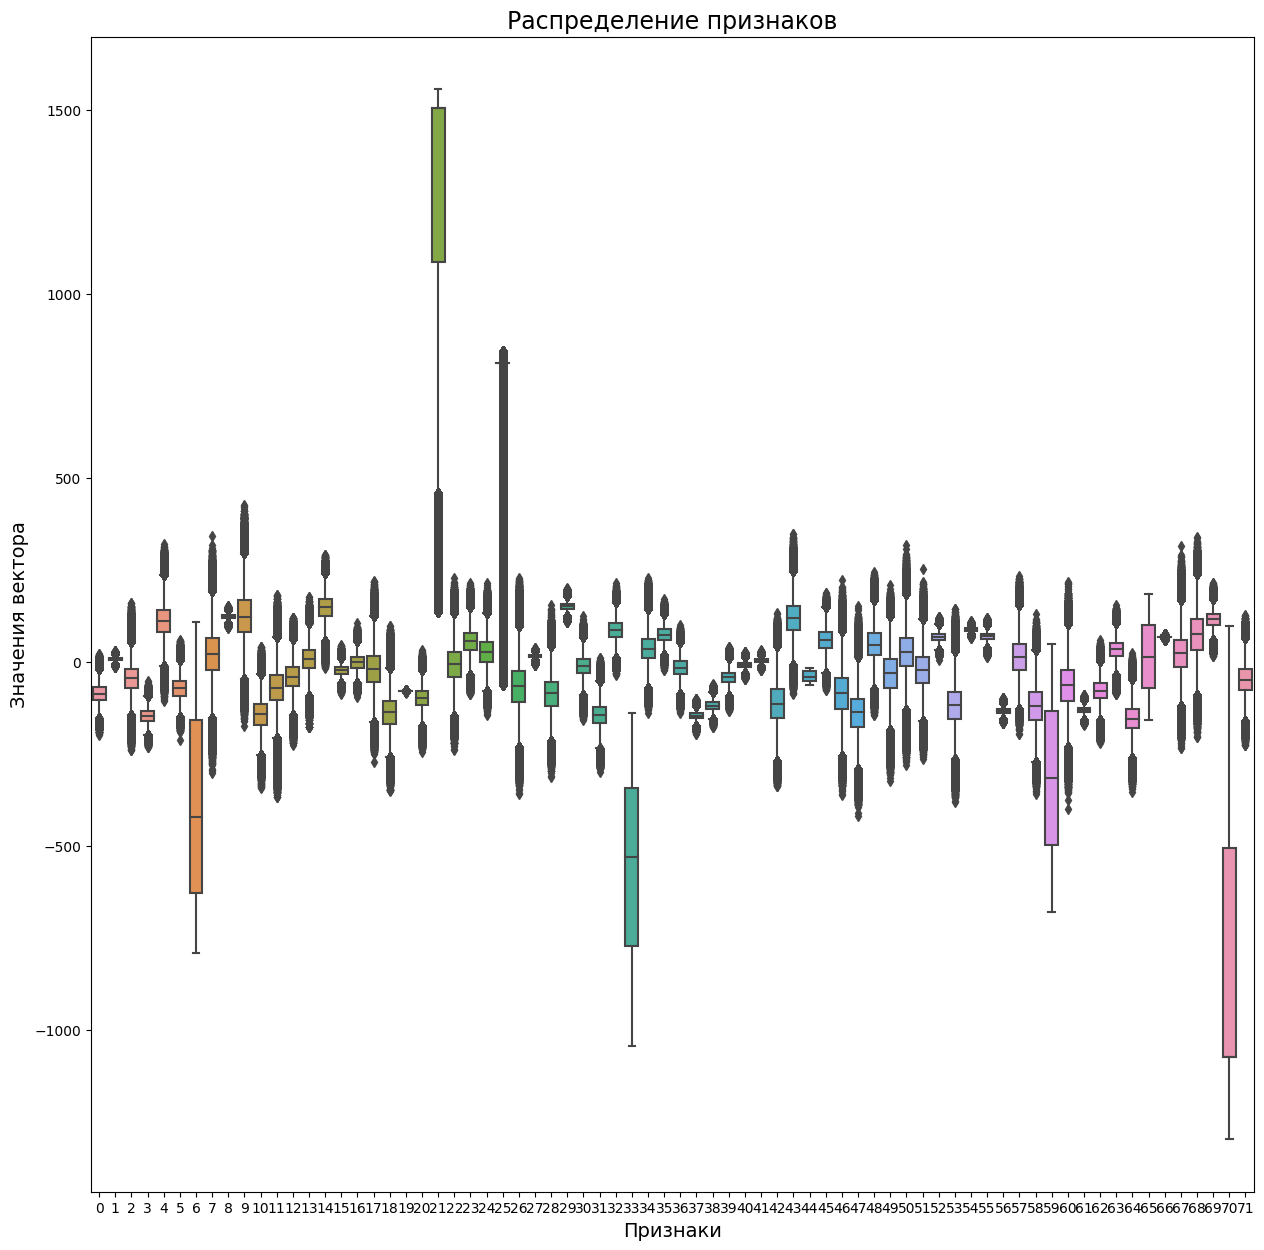

In [87]:
box(base)

In [88]:
inform(train)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  floa

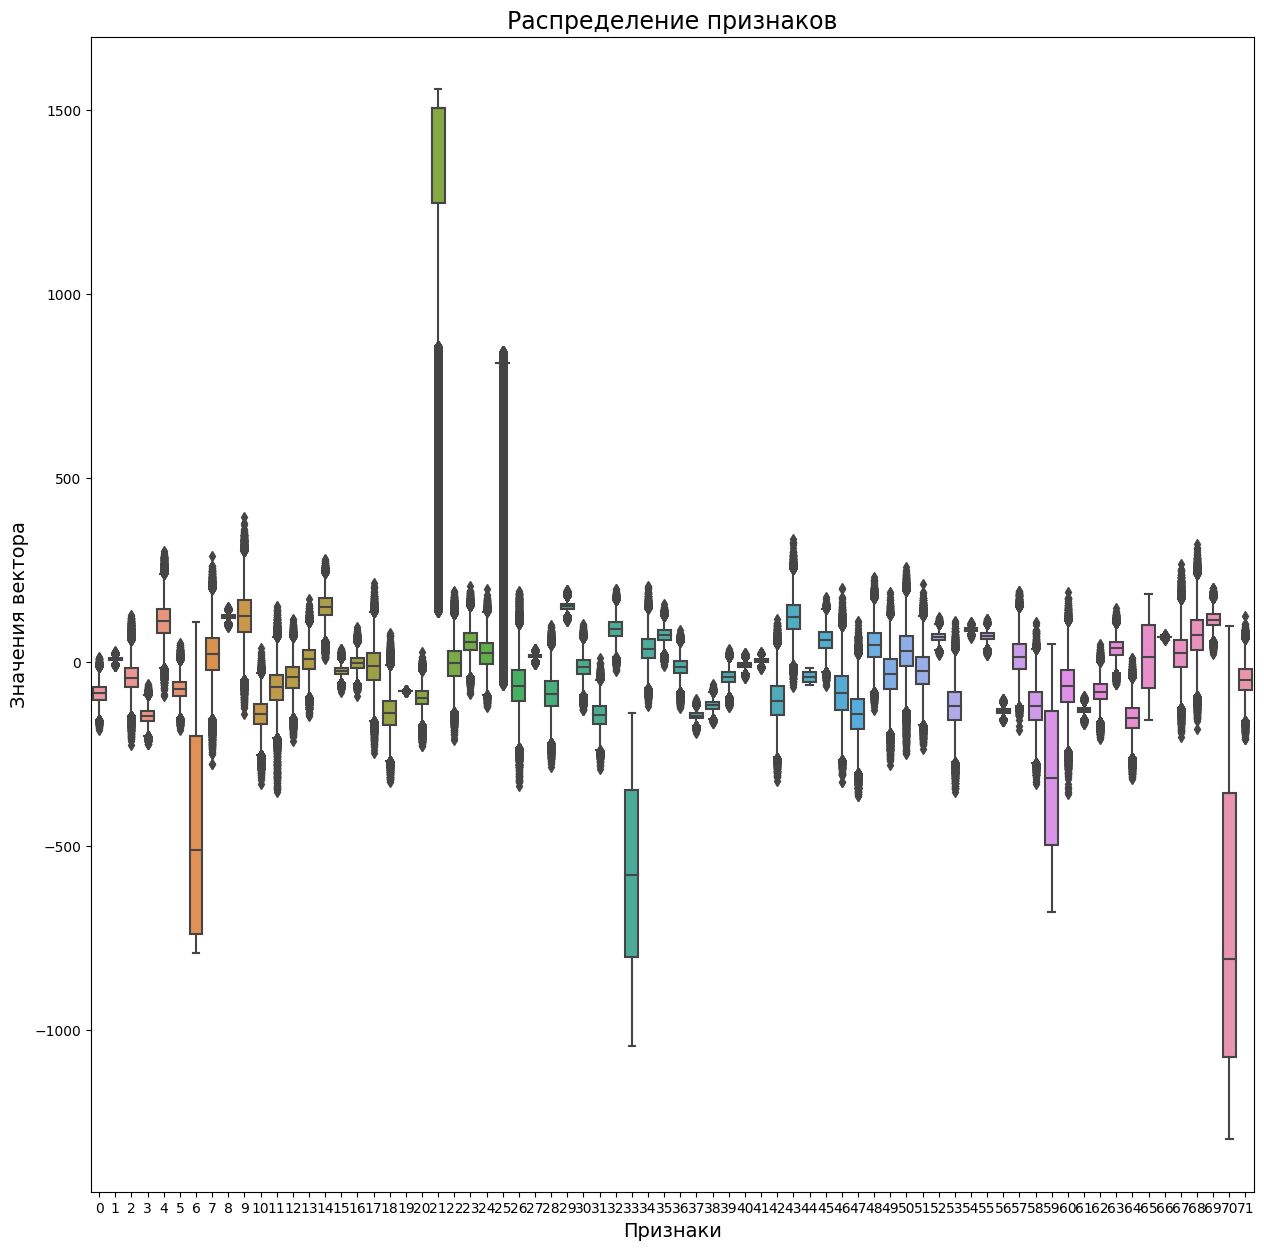

In [89]:
box(train)

In [90]:
    inform(validation)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null

In [91]:
inform(validation_answer)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
None
**************************************************
           Expected
count        100000
unique        91502
top     210304-base
freq              7
**************************************************
Количество пропущенных значений: Expected    0
dtype: int64
**************************************************
Количество дубликатов: 8498


Пропущенных значений, дубликатов нет, все признаки в формате float64.

## Create index

In [92]:
dims = base.shape[1]

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [93]:
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))

In [94]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}
#del df_base

## First model

In [95]:
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

In [96]:
vecs, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

8.195


### EDA

In [97]:
df_samples = train[:5000] #возьмем срез данных для экономии ресурсов

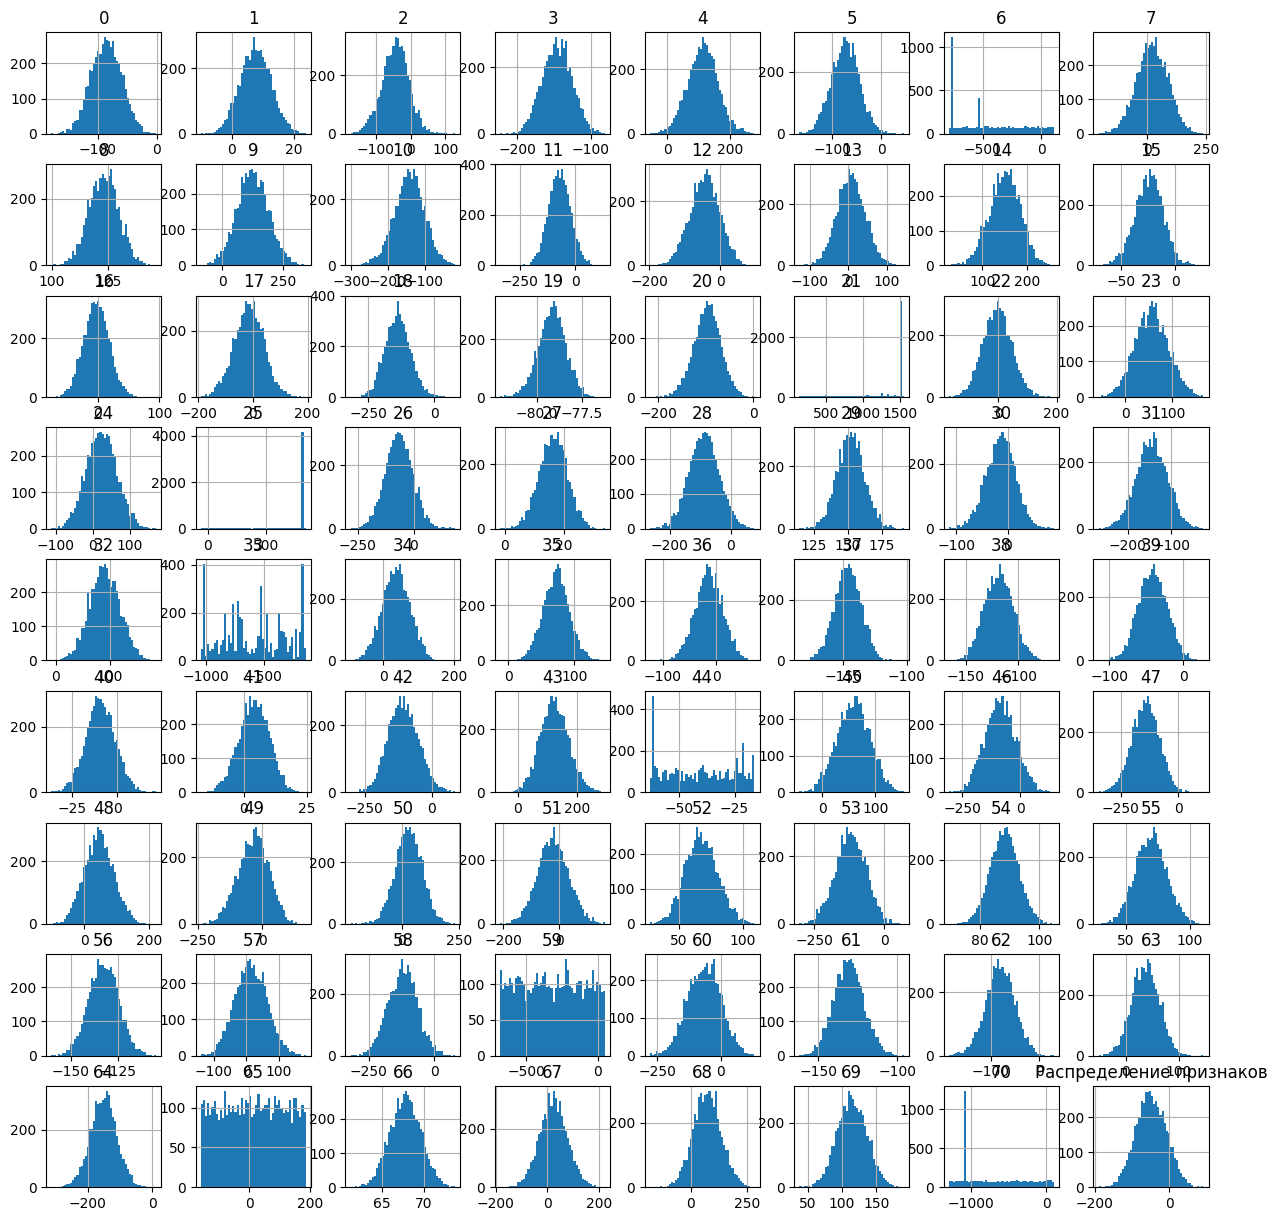

In [98]:
df_samples.hist(figsize=[15, 15], bins=50)
plt.title('Распределение признаков')
plt.show()

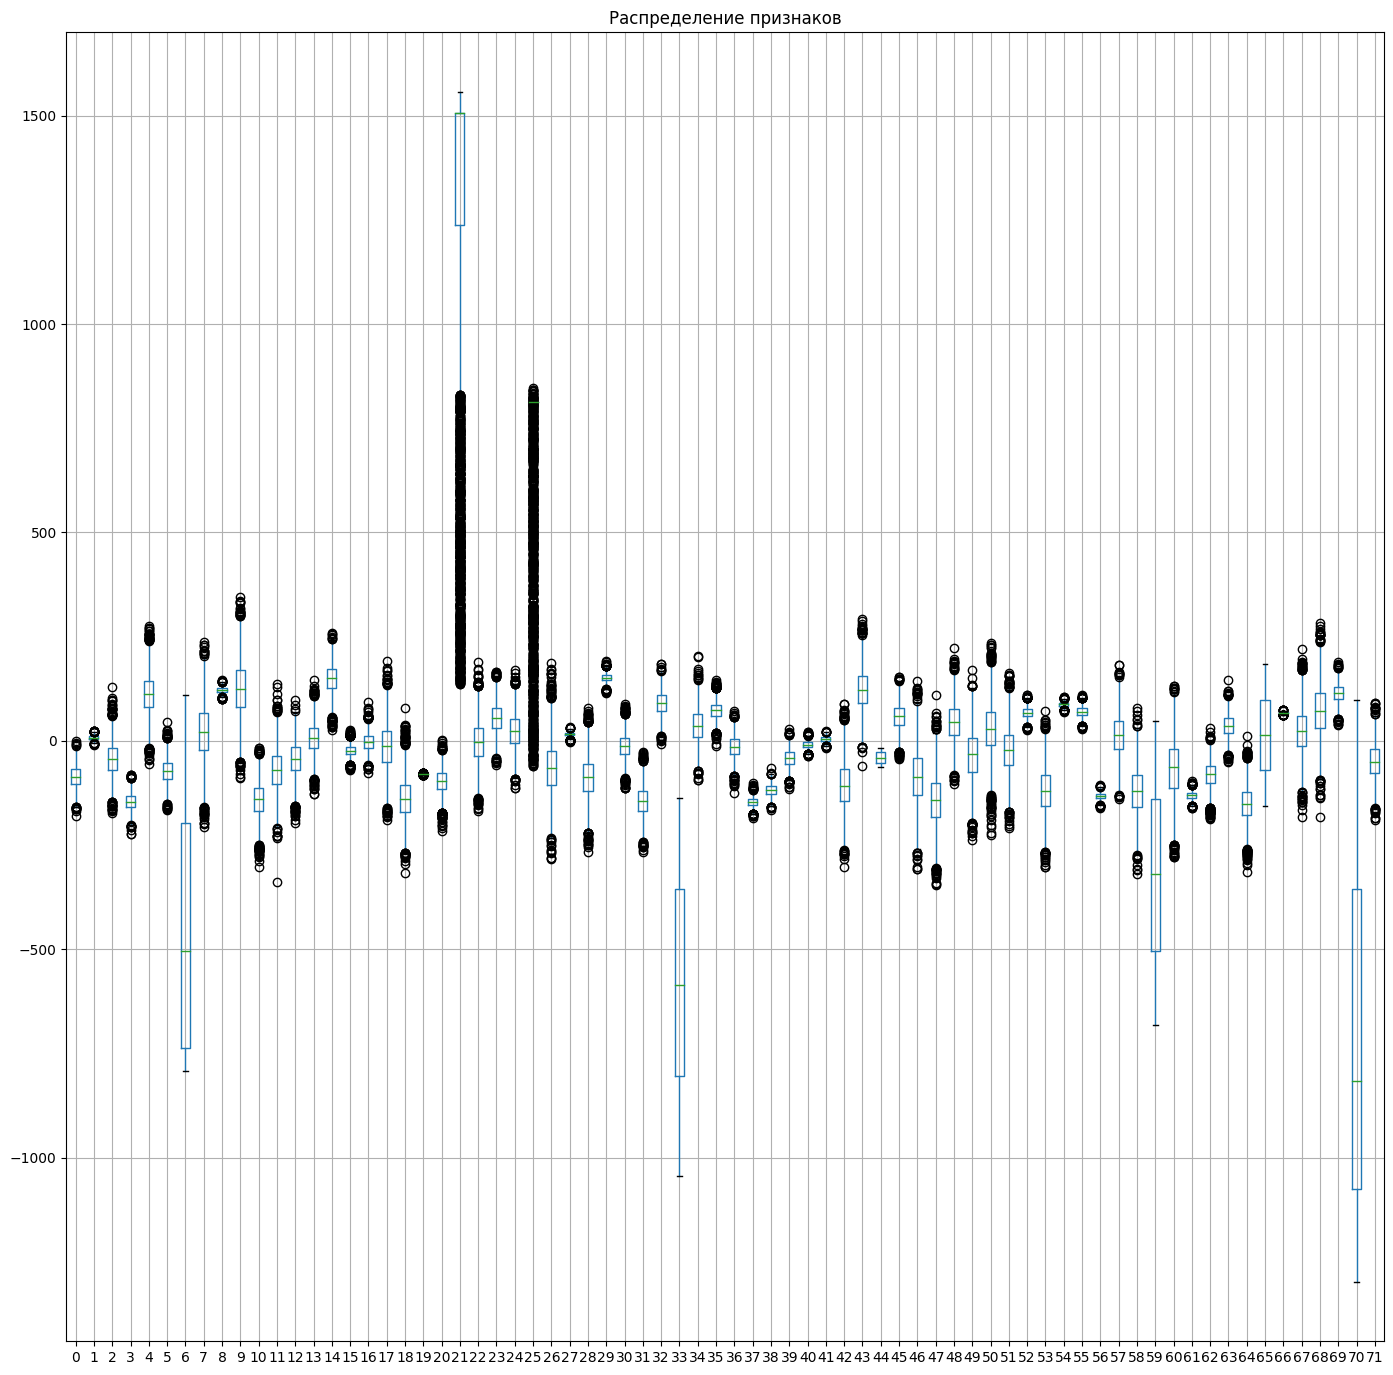

In [99]:
df_samples.boxplot(figsize=[17, 17])
plt.title('Распределение признаков')
plt.show()

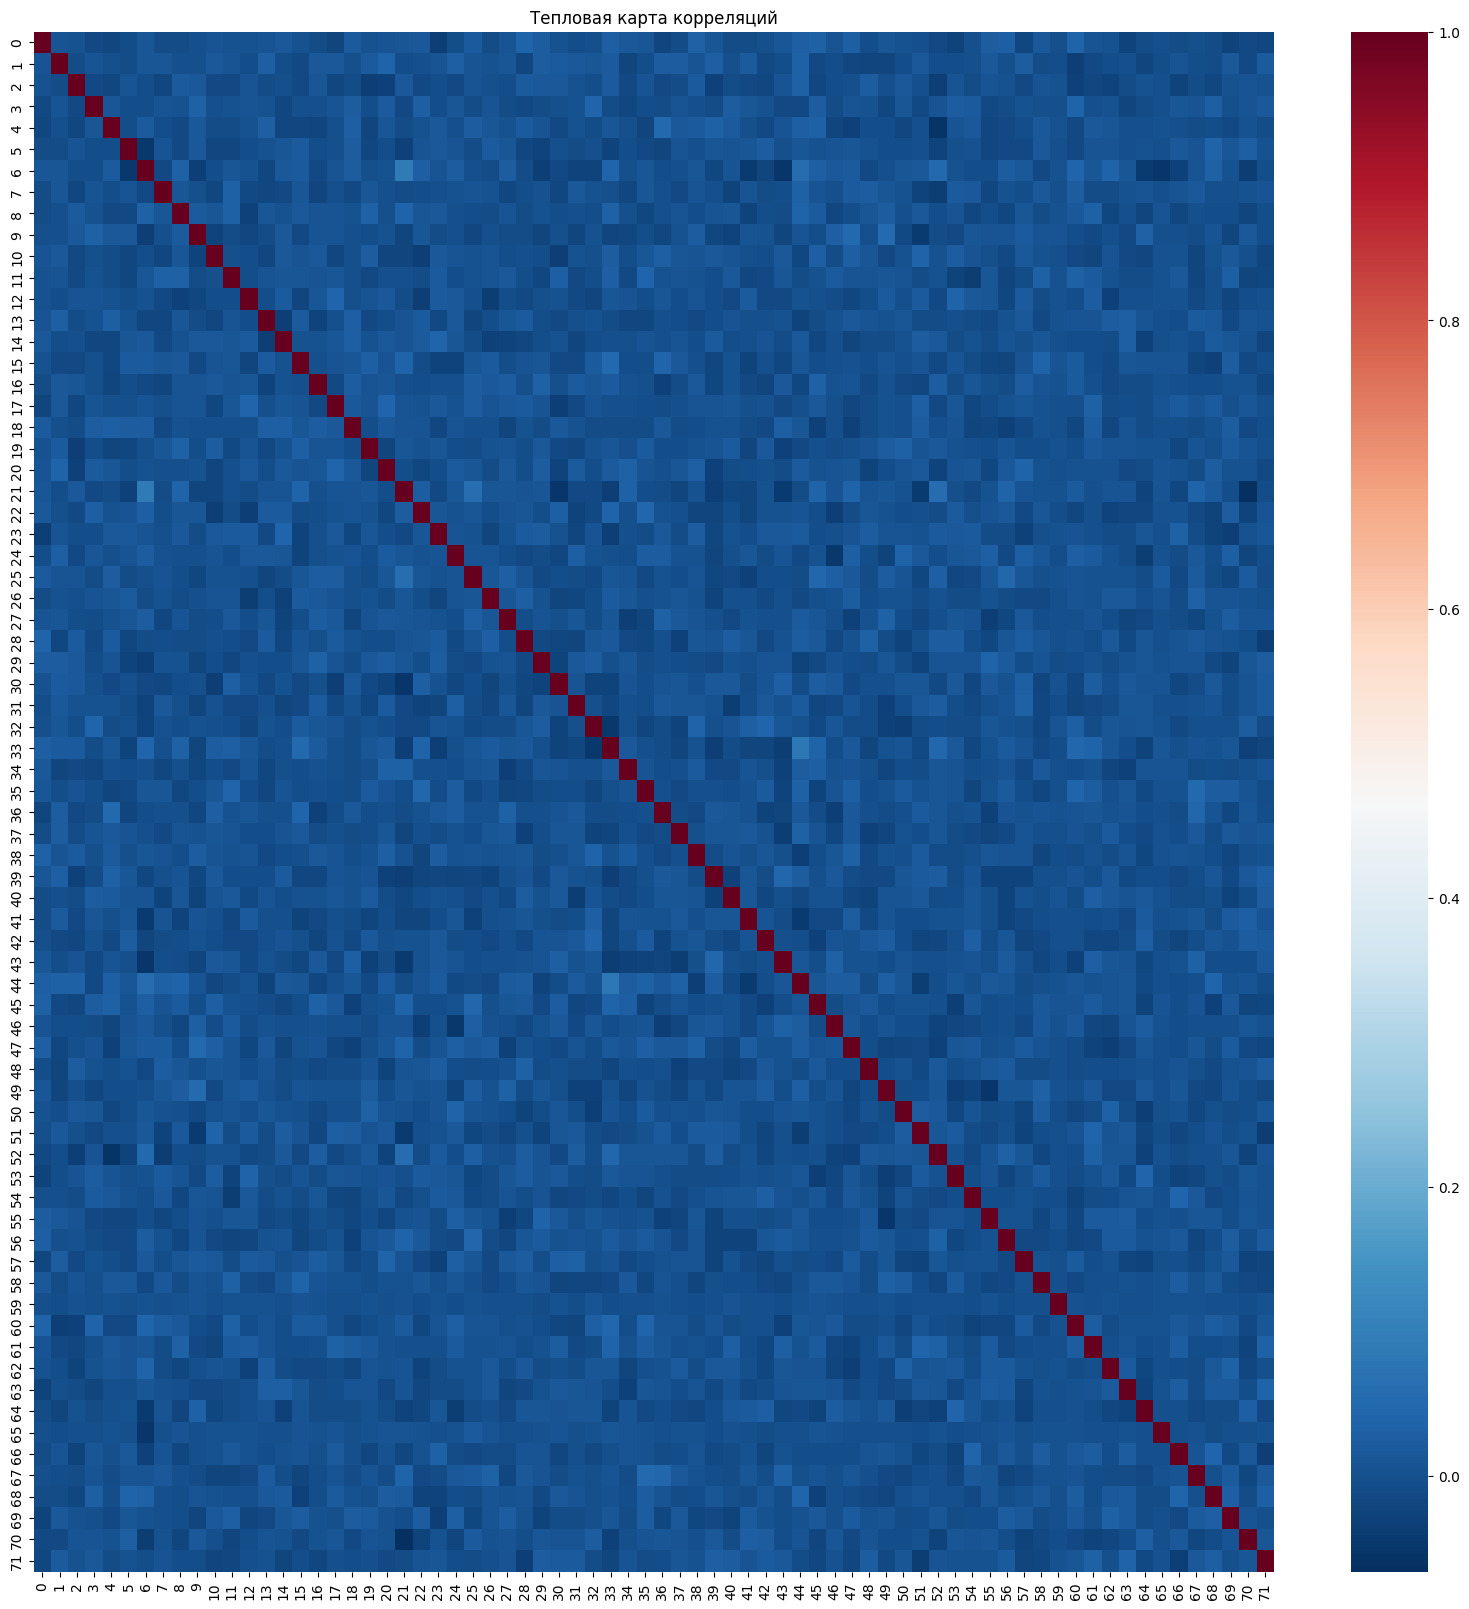

In [100]:
plt.figure(figsize=(20,20))
sns.heatmap(
    train.corr(),
    cmap='RdBu_r')

plt.title("Тепловая карта корреляций")
plt.show()

По корреляции не видим сильных зависимостей

Рассмотрим более подробно признаки с отличным распределением.

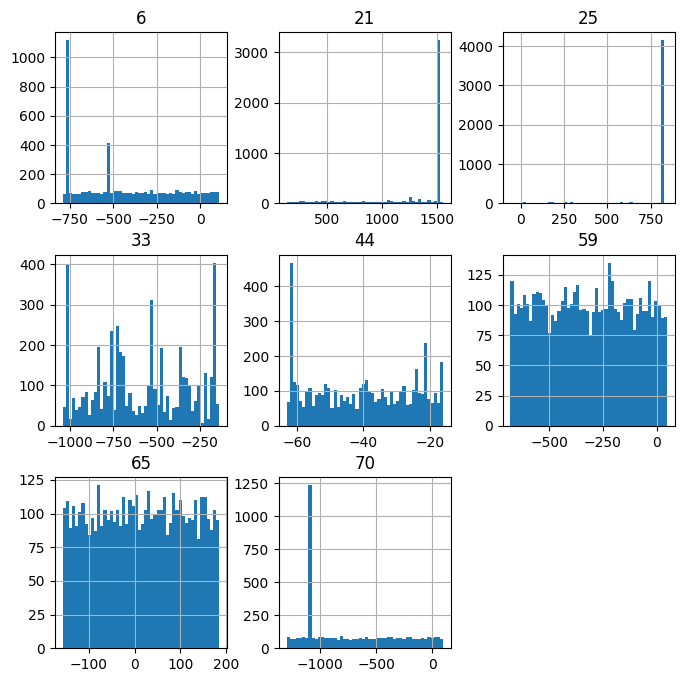

In [101]:
df_samples[['6', '21', '25', '33', '44', '59', '65', '70']].hist(figsize=[8, 8], bins=50)
plt.show()

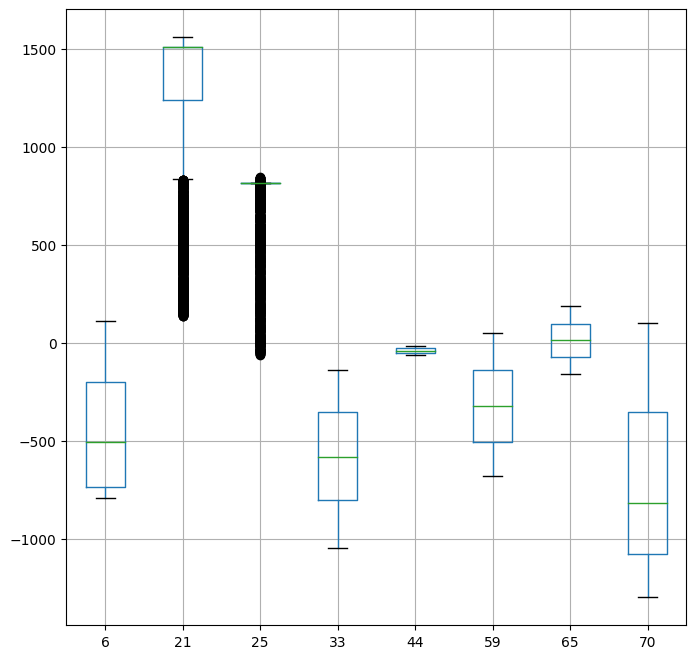

In [102]:
  df_samples[['6', '21', '25', '33', '44', '59', '65', '70']].boxplot(figsize=[8, 8])
  plt.show()


Удалим признаки с ненормальным распределением.

In [103]:
base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)
train.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)

#

## Нормализация данных

In [104]:
scaler = RobustScaler()

base = scaler.fit_transform(base)
train = scaler.transform(train)

dims = base.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(base[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base).astype('float32'))
r, idx = idx_l2.search(np.ascontiguousarray(train).astype('float32'), k)



acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(100 * acc / len(idx))

62.772


Результат метрики точности был достигнут только 62.772 %